# Usando funções

### Função que realiza busca na internet

In [1]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
results = serper.run(query="Capital do Brasil?")

In [2]:
results

"Brasília is the capital city of Brazil and the Federal District. Located in the Brazilian highlands in the country's Central-West region, it was founded by ... The current capital of Brazil, since its construction in 1960, is Brasília. Rio de Janeiro was the country's capital between 1763 and 1960. A capital do Brasil é Brasília. Cada Estado brasileiro possui uma capital ... Capital da Bahia (BA), Salvador foi a primeira capital do Brasil. Sofreu ... Brasília é a capital federal do Brasil e a sede do governo do Distrito Federal. Está localizada na região Centro-Oeste do país, ao longo da região ... Brasília é atualmente a capital do Brasil e sede do governo do Distrito Federal. A atual capital do Brasil é Brasília, localizada na Região Centro-Oeste, ... Sede dos poderes nacionais, Brasília é símbolo modernista aplaudido no mundo todo que atrai curiosidade não somente pela política, ... Today São Paulo, while Rio remains the historical capital of Brazil and the capital of the tourist i

In [3]:
from langchain.agents import Tool

tool_search = Tool(
    name="search tool",
    func=serper.run,
    description="Útil para buscar coisas na internet de forma online"
)

In [4]:
tool_search.invoke("Quem foi lebron james?")

'LeBron James: American basketball power forward. LeBron Raymone James Sr. is an American professional basketball player for the Los Angeles Lakers of the National Basketball Association. LeBron James Born: December 30, 1984 (age 40 years), Akron, OH. LeBron James Current teams: Los Angeles Lakers (#23 / Power forward, Small forward) and United States of America. LeBron James Dates joined: 2018 ( Los Angeles Lakers ), 2014 ( Cleveland Cavaliers ), 2010 ( Miami Heat ), and more. LeBron James Net worth: 1.2 billion USD (2025). LeBron James Spouse: Savannah James (m. 2013). LeBron James Teammates: Stephen Curry, Kobe Bryant, Kevin Durant, and more. LeBron James Children: Bronny James and Bryce James. LeBron Raymone James (Akron, 30 de dezembro de 1984) é um basquetebolista norte-americano que atua como ala pelo Los Angeles Lakers. Um dos maiores jogadores de basquete de todos os tempos. Saiba mais sobre a sua carreira na NBA e as estatísticas internacionais do medalhista de ouro ... LeBro

### Função que manda mensagem no telegram

In [5]:
import requests
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv(find_dotenv())

chat_id = os.getenv("TELEGRAM_CHAT_ID")
token = os.getenv("TELEGRAM_TOKEN")

def send_message(msg):
    """
    Função que manda mensagem para o telegram

    ----------
    parameters
    ----------

    msg: str
        - parâmetro contendo a mensagem que será enviada
    """
    data = {"chat_id": chat_id, "text": msg}
    url = "https://api.telegram.org/bot{}/sendMessage".format(token)
    requests.post(url, data)

In [6]:
tool_notification = Tool(
    name="tool que notifica via telegram",
    func=send_message,
    description="Função que manda mensagem para o telegram"
)

In [7]:
tool_notification.invoke(input={"msg":"Eai cara"})

### Função que realiza a divisão de 2 números

In [8]:
from langchain_core.tools import tool

@tool
def tool_calculator(a: int, b: int) -> int:
    """Dividindo dois números"""
    return a / b


def handle_math_errors(e: ZeroDivisionError) -> str:
    return "Não dá para dividir por zero, meu chapa!"

In [9]:
tools = [tool_search, tool_notification, tool_calculator]

# Criando grafo

In [10]:
# langgraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages

# langchain
from langchain_groq import ChatGroq

# typing
from typing import TypedDict, Annotated

# others
import gradio as gr
from IPython.display import Image, display

/home/rmede/projects/agents-course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Criando o estado

In [11]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Iniciando o construtor de grafo

In [12]:
graph_builder = StateGraph(State)

# Criando nó

In [13]:
llm = ChatGroq(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    temperature=0,
    max_tokens=300
)

llm_with_tools = llm.bind_tools(tools)

In [14]:
def chatbot_node(old_state: State) -> State:
    # Como estamos usando o typed dict ao invés de BaseModel
    response = llm_with_tools.invoke(old_state["messages"])
    return {"messages": [response]}

graph_builder.add_node("chatbot_node", chatbot_node)
graph_builder.add_node("tools_node", ToolNode(tools=tools, handle_tool_errors=handle_math_errors))

# Criando edges

In [15]:
graph_builder.add_conditional_edges(
    "chatbot_node",
    tools_condition,
    {"tools": "tools_node", "__end__": "__end__"}
)

graph_builder.add_edge("tools_node", "chatbot_node")
graph_builder.add_edge(START, "chatbot_node")


# Compilando o grafo

In [16]:
graph = graph_builder.compile()

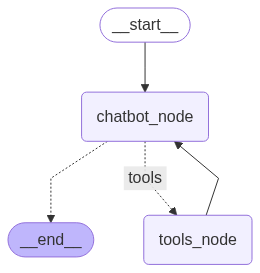

In [17]:
display(Image(graph.get_graph().draw_mermaid_png()))

# Rodando tudo

In [ ]:
# Criando função apenas para rodar no gradio
def chat(user_input: str, history):
    result = graph.invoke(
        {
            "messages": [
                {
                    "role": "user",
                    "content": user_input
                }
            ]
        }
    )

    print(result)
    return result["messages"][-1].content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Me mande uma msg no telegram com a temperatura que são paulo vai estar às 19h', additional_kwargs={}, response_metadata={}, id='b5798a74-dfeb-4ba5-ab17-1990d56886b3'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '5jgwgfe2t', 'function': {'arguments': '{"__arg1":"Temperatura em São Paulo às 19h"}', 'name': 'search tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 792, 'total_tokens': 833, 'completion_time': 0.097196555, 'prompt_time': 0.027786442, 'queue_time': 0.274291164, 'total_time': 0.124982997}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_42ae451038', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c10b2a9b-2391-4c4e-8197-ed0843e41a7d-0', tool_calls=[{'name': 'search tool', 'args': {'__arg1': 'Temperatura em São Paulo às 19h'}, 'id': '5jgwgfe2t', 'type': 'tool_call'}], usage_metadata={'inpu